In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os

In [7]:

os.getcwd()

'c:\\GitHub\\2024DriveBase\\src\\main\\java\\frc\\robot\\utils'

['x', 'y', 'heading', 'dx', 'dy', 'dtheta']
[('x', 'dx'), ('y', 'dy'), ('heading', 'dtheta')]


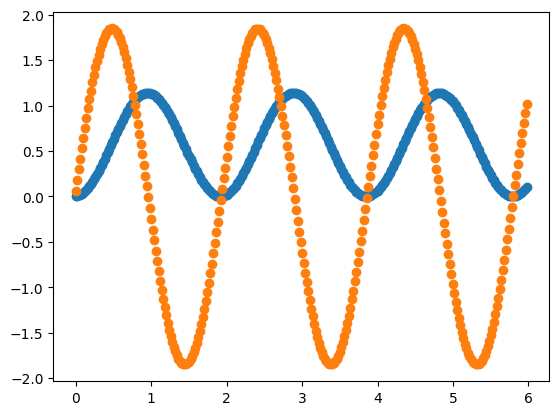

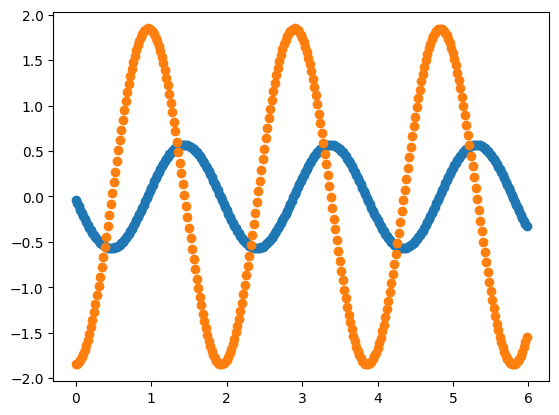

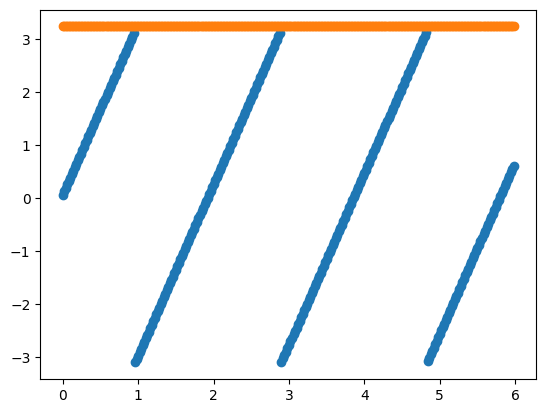

In [42]:
# GET DATA FROM CSV (generated from robot code) #
def get_data_from_csv(path):
    data = {}
    headings = []
    dt = 0.02

    # lol plz tell me there's a better way to write that path...
    with open(path ,'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if i == 0:
                line = line.strip()
                line = line.split(',')
                for heading in line:
                    headings.append(heading[1:-1]) # [1:-1] removes the quotes
                    data[heading[1:-1]] = []
                continue
                
            line = line.strip()
            line = line.split(',')
            for i, value in enumerate(line):
                data[headings[i]].append(float(value[1:-1])) # [1:-1] removes the quotes
                
    data['time'] = [i * dt for i in range(len(data['x']))]
    return data, headings

data, headings = get_data_from_csv('../../../../../../data/circleTestTrajectory.csv')

print(headings)
paired_headings = [(headings[i], headings[i+int(len(headings)/2)]) for i in range(0, int(len(headings) / 2))]
print(paired_headings)

for pair in paired_headings:
    plt.plot(data['time'], data[pair[0]], 'o')
    plt.plot(data['time'], data[pair[1]], 'o')
    plt.show()

[('x', 'dx'), ('y', 'dy'), ('heading', 'dtheta')]


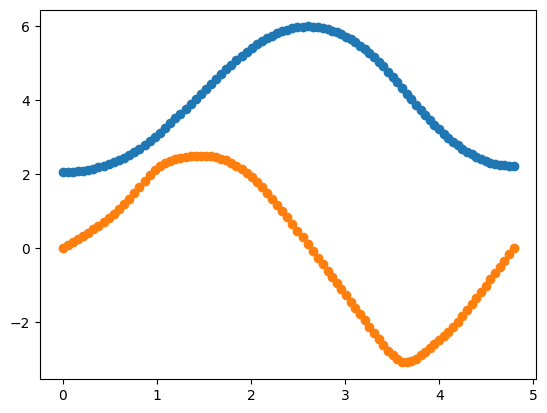

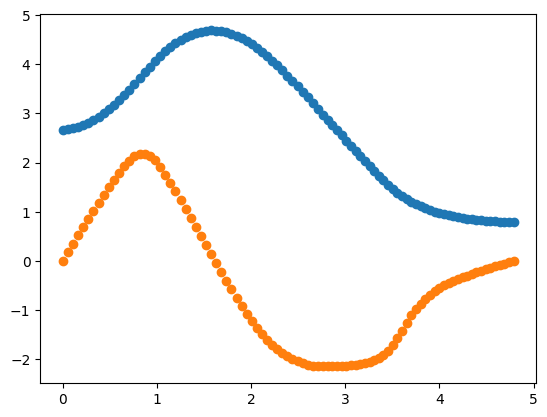

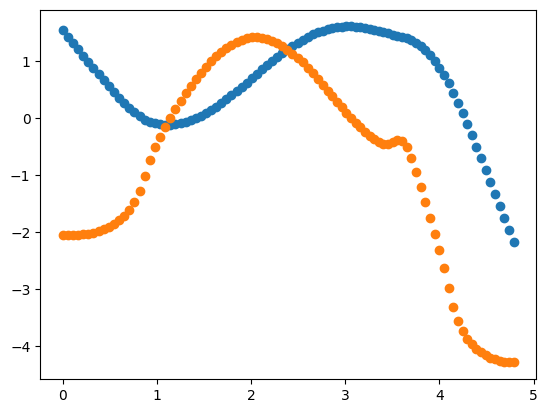

In [14]:
# GET DATA FROM .traj (generated from choreo) #

def get_data_from_traj(traj_path):
    data = {}
    headings = ['x', 'y', 'heading', 'dx', 'dy', 'dtheta', 'time']
    data = {heading: [] for heading in headings}

    for point in pd.read_json(traj_path)['samples']:
        data['x'].append(point['x'])
        data['y'].append(point['y'])
        data['heading'].append(point['heading'])
        data['dx'].append(point['velocityX'])
        data['dy'].append(point['velocityY'])
        data['dtheta'].append(point['angularVelocity'])
        data['time'].append(point['timestamp'])

    return data
headings = ['x', 'y', 'heading', 'dx', 'dy', 'dtheta', 'time']
data = get_data_from_traj('../../../../../../data/NewPath.traj')

paired_headings = [(headings[i], headings[i+int(len(headings)/2)]) for i in range(0, int(len(headings) / 2))]
print(paired_headings)

for pair in paired_headings:
    plt.plot(data['time'], data[pair[0]], 'o')
    plt.plot(data['time'], data[pair[1]], 'o')
    plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output
import matplotlib.colors as mcolors
import ipywidgets as widgets

fig, ax = plt.subplots()

x_lim = [min(data['x']), max(data['x'])]
y_lim = [min(data['y']), max(data['y'])]

# adjust the x and y limits by a factor of 1.1 to make sure nothing is cut off
x_lim = [x_lim[0] - 0.1 * (x_lim[1] - x_lim[0]), x_lim[1] + 0.1 * (x_lim[1] - x_lim[0])]
y_lim = [y_lim[0] - 0.1 * (y_lim[1] - y_lim[0]), y_lim[1] + 0.1 * (y_lim[1] - y_lim[0])]

def format_axis(ax):
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_aspect('equal')
    ax.grid()
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('Robot Trajectory')

# Create a function to update the plot when the slider is moved
def update_plot(frame):
    i = frame.new
    ax.clear()
    format_axis(ax)

    ax.plot(data['x'][0], data['y'][0], 'bs', markersize=8, label='Start')  # Blue square for start
    ax.plot(data['x'][len(data['x']) - 1], data['y'][len(data['x']) - 1], 'r*', markersize=10, label='End')  # Red star for end
    
    ax.legend()
    ax.annotate(f'Time: {data["time"][i]:.2f}s', (0.95, 0.95), xycoords='axes fraction')  # Display the time
    ax.annotate(
        f"Current pose: ({round(data['x'][i], 2)}, {round(data['y'][i], 2)}) meters at {round(data['heading'][i] * 180 / np.pi, 2)} degrees", 
        (0.01, 0.01), 
        xycoords='axes fraction'
    ) 
    
    draw_robot(data['x'][i], data['y'][i], data['heading'][i], ax=ax)
    clear_output(wait=True)
    display(fig)
    display(slider)

# DRAWING THE ROBOT #
def draw_robot(x, y, heading, color='black', ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y, 'o', color=color)
    arrow_scale = 0.03 * max(abs(x_lim[0] - x_lim[1]), abs(y_lim[0] - y_lim[1]))
    ax.arrow(x, y, arrow_scale * np.cos(heading), arrow_scale * np.sin(heading), color=color, width=arrow_scale/5)
    return ax

# update_plot(10)
print(f"Total Frames: {len(data['x'])}")

# Create a slider
slider = widgets.IntSlider(min=0, max=len(data['x'])-1, step=1, value=0)

# Set the method to be called when the slider is updated
slider.observe(update_plot, names='value')

# Display the slider
# display(fig)
display(slider)

In [13]:
### SPLIT TRAJECTORY ###
import json

# TRAJECTORY MUST HAVE BEEN LOADED ABOVE #
print(data.keys())

def split_from_frames(frames):
    new_data = []
    for i in range(len(frames)):
        current_frame = frames[i]
        prev_frame = frames[i-1] if i > 0 else 0

        new_data.append({
            'x': data['x'][prev_frame:current_frame+1],
            'y': data['y'][prev_frame:current_frame+1],
            'heading': data['heading'][prev_frame:current_frame+1],
            'dx': data['dx'][prev_frame:current_frame+1],
            'dy': data['dy'][prev_frame:current_frame+1],
            'dtheta': data['dtheta'][prev_frame:current_frame+1],
            'time': data['time'][prev_frame:current_frame+1]
        })

    new_data.append({
            'x': data['x'][frames[-1]:len(data['x'])+1],
            'y': data['y'][frames[-1]:len(data['x'])+1],
            'heading': data['heading'][frames[-1]:len(data['x'])+1],
            'dx': data['dx'][frames[-1]:len(data['x'])+1],
            'dy': data['dy'][frames[-1]:len(data['x'])+1],
            'dtheta': data['dtheta'][frames[-1]:len(data['x'])+1],
            'time': data['time'][frames[-1]:len(data['x'])+1]
        })

    return new_data


def split_from_translations(pts):
    frames = []
    # Don't @ me abt this time complexity... im lazy
    for point in pts:
        print(point)
        valid_frames = []
        for i, (x, y) in enumerate(zip(data['x'], data['y'])):
            # print(x, y)
            if (x == point[0] and y == point[1]):
                valid_frames.append(i)
        if len(valid_frames) == 0:
            print("Split failed: One of your chosen points is not in the trajectory! All points must be EXACT (no rounding!)")
            return
        if len(valid_frames) > 1:
            print("Split failed: One of your chosen points occurs twice in the trajectory! Please specify exact frames instead.")
            return
        frames.append(*valid_frames)
    return split_from_frames(frames)


def data_to_traj(data):
    traj = []
    for i in range(len(data['x'])):
        traj.append({
            'x': data['x'][i],
            'y': data['y'][i],
            'heading': data['heading'][i],
            'velocityX': data['dx'][i],
            'velocityY': data['dy'][i],
            'angularVelocity': data['dtheta'][i],
            'timestamp': data['time'][i]
        })
    return {
        "samples": traj
    }

def save_traj_to_file(traj, file_path):
    # Split the file_path into directory and file name
    directory, file_name = os.path.split(file_path)

    # Create the directory if it does not exist
    os.makedirs(f'../../../../deploy/choreo/{directory}', exist_ok=True)
    
    with open(f'../../../../deploy/choreo/{file_path}.traj', 'w') as f:
        json.dump(traj, f)

def save_splits(trajs, file_path):
    for i, traj in enumerate(trajs):
        save_traj_to_file(traj, f"{file_path}_{i}")

# save_traj_to_file(data_to_traj(data), "test/test")

pts = [(5.913945149366892, 3.7691250692317153), (3.465748730105329, 1.032999247779862)]
save_splits([data_to_traj(new_data) for new_data in split_from_translations(pts)], "test/test")

dict_keys(['x', 'y', 'heading', 'dx', 'dy', 'dtheta', 'time'])
(5.913945149366892, 3.7691250692317153)
(3.465748730105329, 1.032999247779862)


0.02


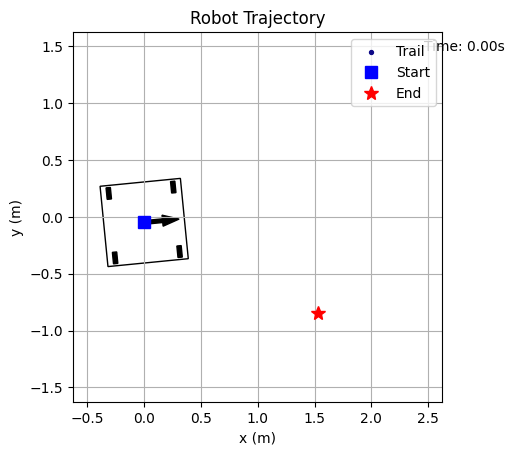

In [48]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.transforms as transforms


# data = get_data_from_traj("../../../../deploy/choreo/test/test_2.traj")
data = get_data_from_csv('../../../../../../data/circleTestTrajectory.csv')[0]
# print(data)
# trajectories = [
#     # get_data_from_csv('../../../../../../data/trajectory.csv')[0],
#     get_data_from_csv('../../../../../../data/choreoTrajectory.csv')[0]
# ]

fig, ax = plt.subplots()

robot_dimentions = [0.71, 0.71] # width, length of robot
track_width = .57 # distance between wheels
wheel_radius = .0508 # radius of wheels
wheel_width = .0381 # width of wheels

x_lim = [min(data['x']) - robot_dimentions[0]/2, max(data['x']) + robot_dimentions[0]/2]
y_lim = [min(data['y']) - robot_dimentions[1]/2, max(data['y']) + robot_dimentions[1]/2]

# adjust the x and y limits by a factor of 1.1 to make sure nothing is cut off
x_lim = [x_lim[0] - 0.1 * (x_lim[1] - x_lim[0]), x_lim[1] + 0.1 * (x_lim[1] - x_lim[0])]
y_lim = [y_lim[0] - 0.1 * (y_lim[1] - y_lim[0]), y_lim[1] + 0.1 * (y_lim[1] - y_lim[0])]

def format_axis(ax):
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_aspect('equal')
    ax.grid()
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('Robot Trajectory')

# Create a colormap for the trail
# cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue", "green", "yellow", "red"])
cmap = plt.get_cmap('plasma')

# # Calculate the velocity
# data['vx'] = np.gradient(data['x'], dt)
# data['vy'] = np.gradient(data['y'], dt)
# data['v'] = np.sqrt(data['vx']**2 + data['vy']**2)

# # Normalize the velocity for the colormap
# v_norm = data['v'] / max(data['v'])

# dt = data['time'][1] - data['time'][0]
dt = 0.02
print(dt)

# DRAWING THE ROBOT #
def draw_robot(x, y, heading, color='black', ax=None):
    if ax is None:
        ax = plt.gca()

    # Create a rectangle representing the robot
    robot_width, robot_length = robot_dimentions
    robot = patches.Rectangle((x - robot_width / 2, y - robot_length / 2), robot_width, robot_length, color=color, fill=False)

    # Create a transformation that rotates the rectangle around its center
    t = transforms.Affine2D().rotate_around(x, y, heading) + ax.transData
    robot.set_transform(t)

    # Add the rectangle to the plot
    ax.add_patch(robot)

    # Add a dot at the center of the robot
    ax.scatter(x, y, color='red')

    # Add rectangles for wheels
    wheel_x_offsets = [track_width / 2, track_width / 2, -track_width / 2, -track_width / 2]
    wheel_y_offsets = [track_width / 2, -track_width / 2, track_width / 2, -track_width / 2]
    wheel_positions = [(x + offset_x * np.cos(heading) - offset_y * np.sin(heading), y + offset_x * np.sin(heading) + offset_y * np.cos(heading)) for offset_x, offset_y in zip(wheel_x_offsets, wheel_y_offsets)]
    for wheel_position in wheel_positions:
        wheel = patches.Rectangle((wheel_position[0] - wheel_width / 2, wheel_position[1] - wheel_radius), wheel_width, 2 * wheel_radius, color='black')
        t = transforms.Affine2D().rotate_around(wheel_position[0], wheel_position[1], heading) + ax.transData
        wheel.set_transform(t)
        ax.add_patch(wheel)

    arrow_scale = 0.05 * max(abs(x_lim[0] - x_lim[1]), abs(y_lim[0] - y_lim[1]))
    ax.arrow(x, y, arrow_scale * np.cos(heading), arrow_scale * np.sin(heading), color=color, width=arrow_scale/5)
    return ax

# ANIMATION #
def animate(i):
    ax.clear()
    format_axis(ax)

    # Only run every few frames ([:i+1:num_skipped]) to clearly show the separation between trail markers (used to visually show velocity)
    ax.scatter(data['x'][:i+1:2], data['y'][:i+1:2], c=range(0, i+1, 2), s=8, cmap=cmap, label='Trail')

    ax.plot(data['x'][0], data['y'][0], 'bs', markersize=8, label='Start')  # Blue square for start
    ax.plot(data['x'][len(data['x']) - 1], data['y'][len(data['x']) - 1], 'r*', markersize=10, label='End')  # Red star for end
    
    ax.legend()
    ax.annotate(f'Time: {data["time"][i]:.2f}s', (0.95, 0.95), xycoords='axes fraction')  # Display the time
    
    draw_robot(data['x'][i], data['y'][i], data['heading'][i], ax=ax)

# draw_robot(data['x'][0], data['y'][0], data['heading'][0], ax=ax)
# plt.show()

speed = 1 # playback speed (1 = real time)
ani = FuncAnimation(fig, animate, frames=len(data['x']), interval=1/speed * (dt * 1000))


# Display the animation in the Jupyter notebook
HTML(ani.to_html5_video())

[-0.5994863884548817, 6.595286496104702]
0.02


KeyboardInterrupt: 

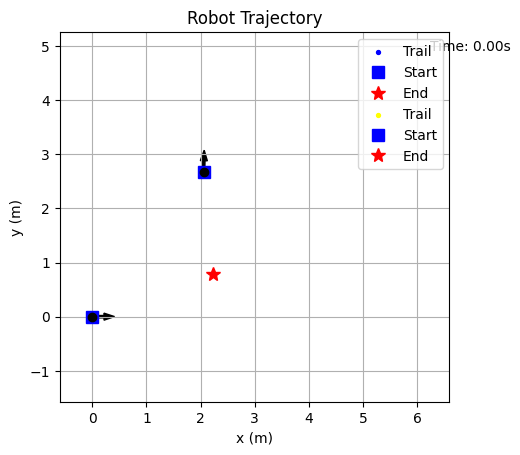

In [34]:
### ANIMATE MULTIPLE TRAJECTORIES ###

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.colors as mcolors

# data = get_data_from_traj("../../../../deploy/choreo/test/test_2.traj")
# data = get_data_from_csv('../../../../../../data/trajectory.csv')[0]
# print(data)
trajectories = [
    get_data_from_csv('../../../../../../data/choreoTrajectory.csv')[0],
    get_data_from_csv('../../../../../../data/trajectory.csv')[0]
]

fig, ax = plt.subplots()


for i, traj in enumerate(trajectories):
    if i == 0:
        x_lim = [min(traj['x']), max(traj['x'])]
        y_lim = [min(traj['y']), max(traj['y'])]
        continue
    
    x_lim = [
        min(x_lim[0], min(data['x'])), 
        max(x_lim[1], max(data['x']))
    ]
    y_lim = [
        min(y_lim[0], min(data['y'])), 
        max(y_lim[1], max(data['y']))
    ]

# adjust the x and y limits by a factor of 1.1 to make sure nothing is cut off
x_lim = [x_lim[0] - 0.1 * (x_lim[1] - x_lim[0]), x_lim[1] + 0.1 * (x_lim[1] - x_lim[0])]
y_lim = [y_lim[0] - 0.1 * (y_lim[1] - y_lim[0]), y_lim[1] + 0.1 * (y_lim[1] - y_lim[0])]

print(x_lim)

def format_axis(ax):
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_aspect('equal')
    ax.grid()
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('Robot Trajectory')

# Create a colormap for the trail
cmaps = [
    mcolors.LinearSegmentedColormap.from_list("", ["blue", "green"]),
    mcolors.LinearSegmentedColormap.from_list("", ["yellow", "red"]),
    mcolors.LinearSegmentedColormap.from_list("", ["purple", "orange"]),
    mcolors.LinearSegmentedColormap.from_list("", ["black", "white"]),
    mcolors.LinearSegmentedColormap.from_list("", ["cyan", "magenta"]),
    mcolors.LinearSegmentedColormap.from_list("", ["pink", "brown"]),
    mcolors.LinearSegmentedColormap.from_list("", ["gray", "olive"]),
    mcolors.LinearSegmentedColormap.from_list("", ["lime", "teal"]),
    mcolors.LinearSegmentedColormap.from_list("", ["indigo", "gold"])
]
# cmap = plt.get_cmap('plasma')

# # Calculate the velocity
# data['vx'] = np.gradient(data['x'], dt)
# data['vy'] = np.gradient(data['y'], dt)
# data['v'] = np.sqrt(data['vx']**2 + data['vy']**2)

# # Normalize the velocity for the colormap
# v_norm = data['v'] / max(data['v'])

# dt = data['time'][1] - data['time'][0]
dt = 0.02
print(dt)

# DRAWING THE ROBOT #
def draw_robot(x, y, heading, color='black', ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y, 'o', color=color)
    arrow_scale = 0.03 * max(abs(x_lim[0] - x_lim[1]), abs(y_lim[0] - y_lim[1]))
    ax.arrow(x, y, arrow_scale * np.cos(heading), arrow_scale * np.sin(heading), color=color, width=arrow_scale/5)
    return ax

# ANIMATION #
def animate(i):
    ax.clear()
    format_axis(ax)

    # Only run every few frames ([:i+1:num_skipped]) to clearly show the separation between trail markers (used to visually show velocity)
    ax.scatter(data['x'][:i+1:2], data['y'][:i+1:2], c=range(0, i+1, 2), s=8, cmap=cmap, label='Trail')

    ax.plot(data['x'][0], data['y'][0], 'bs', markersize=8, label='Start')  # Blue square for start
    ax.plot(data['x'][len(data['x']) - 1], data['y'][len(data['x']) - 1], 'r*', markersize=10, label='End')  # Red star for end
    
    ax.legend()
    ax.annotate(f'Time: {data["time"][i]:.2f}s', (0.95, 0.95), xycoords='axes fraction')  # Display the time
    
    draw_robot(data['x'][i], data['y'][i], data['heading'][i], ax=ax)

def animate_multiple(i):
    ax.clear()
    format_axis(ax)
    for k, traj in enumerate(trajectories):
        if i > len(traj['x']) - 1:
            continue

        # Only run every few frames ([:i+1:num_skipped]) to clearly show the separation between trail markers (used to visually show velocity)
        ax.scatter(traj['x'][:i+1:2], traj['y'][:i+1:2], c=range(0, i+1, 2), s=8, cmap=cmaps[k % len(cmaps)], label='Trail')

        ax.plot(traj['x'][0], traj['y'][0], 'bs', markersize=8, label='Start')  # Blue square for start
        ax.plot(traj['x'][len(traj['x']) - 1], traj['y'][len(traj['x']) - 1], 'r*', markersize=10, label='End')  # Red star for end
        
        draw_robot(traj['x'][i], traj['y'][i], traj['heading'][i], ax=ax)
        time = traj['time'][i]

    ax.legend()
    ax.annotate(f'Time: {time:.2f}s', (0.95, 0.95), xycoords='axes fraction')  # Display the time



# draw_robot(data['x'][0], data['y'][0], data['heading'][0], ax=ax)
# draw_robot(trajectories[0]['x'][0], trajectories[0]['y'][0], trajectories[0]['heading'][0], ax=ax)
# draw_robot(trajectories[1]['x'][50], trajectories[1]['y'][50], trajectories[1]['heading'][50], ax=ax)
# plt.show()

speed = 1 # playback speed (1 = real time)
# ani = FuncAnimation(fig, animate, frames=len(data['x']), interval=1/speed * (dt * 1000))
ani = FuncAnimation(fig, animate_multiple, frames=max([len(traj['x']) for traj in trajectories]), interval=1/speed * (dt * 1000))


# Display the animation in the Jupyter notebook
HTML(ani.to_html5_video())